In this project, we will try to predict flight price, based on features like distance, destination, airline and so on.

In [133]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

#graphs will look nicer
sns.set()

At first let's get to know with data, check null values and types of columns.

In [134]:
df = pd.read_excel('Flight Dataset/Data_Train.xlsx') #load dataset
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [136]:
#calculate number of null values in every column
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [137]:
#there are only 2 null values so get rid of these rows
df = df.dropna()

At first lets convert Date_of_Journey, Dep_Time, Arrival_Time, Duration and Total_Stops columns to numerical values so it will be much easier to work with them

In [138]:
df[["Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration", "Total_Stops"]].head()

,Date_of_Journey,Dep_Time,Arrival_Time,Duration,Total_Stops
0,24/03/2019,22:20,01:10 22 Mar,2h 50m,non-stop
1,1/05/2019,05:50,13:15,7h 25m,2 stops
2,9/06/2019,09:25,04:25 10 Jun,19h,2 stops
3,12/05/2019,18:05,23:30,5h 25m,1 stop
4,01/03/2019,16:50,21:35,4h 45m,1 stop


In [139]:
#Convert Date_of_journey column to day, month and year columns 
datetime = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y")

#create new columns, with numeric values of day, and month
df['Journey_day'] = datetime.dt.day
df['Journey_month'] = datetime.dt.month

In [140]:
#check wheter we have data from multiple years
print("min: ", datetime.dt.year.min())
print("max: ", datetime.dt.year.max())

min:  2019
max:  2019


In [141]:
#drop redundant column
df.drop(['Date_of_Journey'], inplace = True, axis=1)

In [142]:
def dep_t(x):
    """this function will convert string with time to numeric value"""
    x = x.split(":")
    h = int(x[0]) #hour value
    m = int(x[1]) / 60 #minute value divided by 60
    return h + m

#change column with dep_t function
df["Dep_Time"] = df["Dep_Time"].apply(dep_t)
df["Dep_Time"]

0        22.333333
1         5.833333
2         9.416667
3        18.083333
4        16.833333
           ...    
10678    19.916667
10679    20.750000
10680     8.333333
10681    11.500000
10682    10.916667
Name: Dep_Time, Length: 10682, dtype: float64

In [143]:
def dur(x):
    """this functin will extract duration of fly"""
    x = x.split() #split string to hours and minutes
    h = x[0] # hours
    h = int(h[:-1]) # change type from string to integer without last character h
    if len(x) > 1: # if there are some minutes
        m = x[1] # string with minutes
        m = int(m[:-1]) / 60 #change type from string to integer without last character m and divide it by 60
        return h + m 
    return h

#apply dur function
df["Duration"] = df["Duration"].apply(dur)
df["Duration"]

0         2.833333
1         7.416667
2        19.000000
3         5.416667
4         4.750000
           ...    
10678     2.500000
10679     2.583333
10680     3.000000
10681     2.666667
10682     8.333333
Name: Duration, Length: 10682, dtype: float64

In [144]:
def arr_time(x):
    """Extract arrival time"""
    x = x.split()[0] # split string by space and pick firt values - time
    x = x.split(":") # split time string
    h = int(x[0]) # hours
    m = int(x[1]) / 60 # minutes divided by 60 
    return h + m

#apply arr_time func
df["Arrival_Time"] = df["Arrival_Time"].apply(arr_time)
df["Arrival_Time"]

0         1.166667
1        13.250000
2         4.416667
3        23.500000
4        21.583333
           ...    
10678    22.416667
10679    23.333333
10680    11.333333
10681    14.166667
10682    19.250000
Name: Arrival_Time, Length: 10682, dtype: float64

In [145]:
#Create new feature Nights, that will tell the difference in calendar days, between departure and arrival time
df["Nights"] = (df["Dep_Time"] + df["Duration"]) // 24

#print number of distinct values
df["Nights"].value_counts()

0.0    6346
1.0    4285
2.0      51
Name: Nights, dtype: int64

In [146]:
#print all distinct values of Total_Stops column 
df["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [147]:
#lets change Total_stops strings with integers
df['Total_Stops'].replace({'non-stop': 0,'1 stop': 1,'2 stops': 2,'3 stops': 3,'4 stops': 4},inplace=True)
df['Total_Stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10682, dtype: int64

In [148]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Nights
0,IndiGo,Banglore,New Delhi,BLR → DEL,22.333333,1.166667,2.833333,0,No info,3897,24,3,1.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,5.833333,13.250000,7.416667,2,No info,7662,1,5,0.0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,9.416667,4.416667,19.000000,2,No info,13882,9,6,1.0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18.083333,23.500000,5.416667,1,No info,6218,12,5,0.0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16.833333,21.583333,4.750000,1,No info,13302,1,3,0.0


Lets deal with categorical columns now

In [149]:
#remove Route column
df.drop("Route", axis = 1, inplace = True)

In [150]:
#check Airline values 
df["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [151]:
#check Destination values 
df["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [152]:
#check Source values 
df["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [153]:
#check Info values 
df["Additional_Info"].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [154]:
#change type of Airline, Source, Destination and Additional_info columns to category
df =  df.astype({"Airline": "category", "Source": "category", "Destination": "category", "Additional_Info": "category"})   

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Airline          10682 non-null  category
 1   Source           10682 non-null  category
 2   Destination      10682 non-null  category
 3   Dep_Time         10682 non-null  float64 
 4   Arrival_Time     10682 non-null  float64 
 5   Duration         10682 non-null  float64 
 6   Total_Stops      10682 non-null  int64   
 7   Additional_Info  10682 non-null  category
 8   Price            10682 non-null  int64   
 9   Journey_day      10682 non-null  int64   
 10  Journey_month    10682 non-null  int64   
 11  Nights           10682 non-null  float64 
dtypes: category(4), float64(4), int64(4)
memory usage: 794.0 KB


In [156]:
#check correlation of numercial features with price
df.corr()["Price"]

Dep_Time         0.005468
Arrival_Time     0.020901
Duration         0.506604
Total_Stops      0.603897
Price            1.000000
Journey_day     -0.153774
Journey_month   -0.103643
Nights           0.347238
Name: Price, dtype: float64

We can see that most of the numercial features are at least a little bit correlated with price.

Lets see how is price distributed among categorical features

<AxesSubplot:xlabel='Destination', ylabel='Price'>

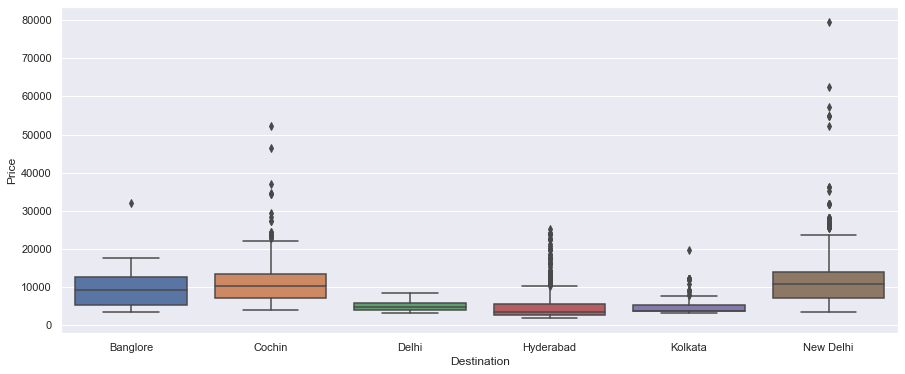

In [157]:
sns.set(rc = {'figure.figsize':(15,6)})

sns.boxplot(x = 'Destination', y = 'Price', data = df)

New Delhi and Cochin destinations has the biggest flight prices, there are even some outliers with really high price.

<AxesSubplot:xlabel='Source', ylabel='Price'>

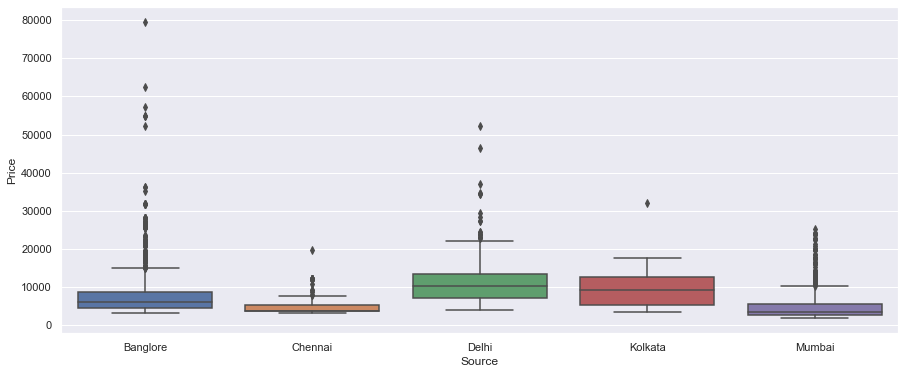

In [158]:
sns.boxplot(x = 'Source', y = 'Price', data = df)

Now let's check if some airlines are more expensive than others.

[Text(0, 0, 'IndiGo'),
 Text(1, 0, 'Air India'),
 Text(2, 0, 'Jet Airways'),
 Text(3, 0, 'SpiceJet'),
 Text(4, 0, 'Multiple carriers'),
 Text(5, 0, 'GoAir'),
 Text(6, 0, 'Vistara'),
 Text(7, 0, 'Air Asia'),
 Text(8, 0, 'Vistara Premium economy'),
 Text(9, 0, 'Jet Airways Business'),
 Text(10, 0, 'Multiple carriers Premium economy'),
 Text(11, 0, 'Trujet')]

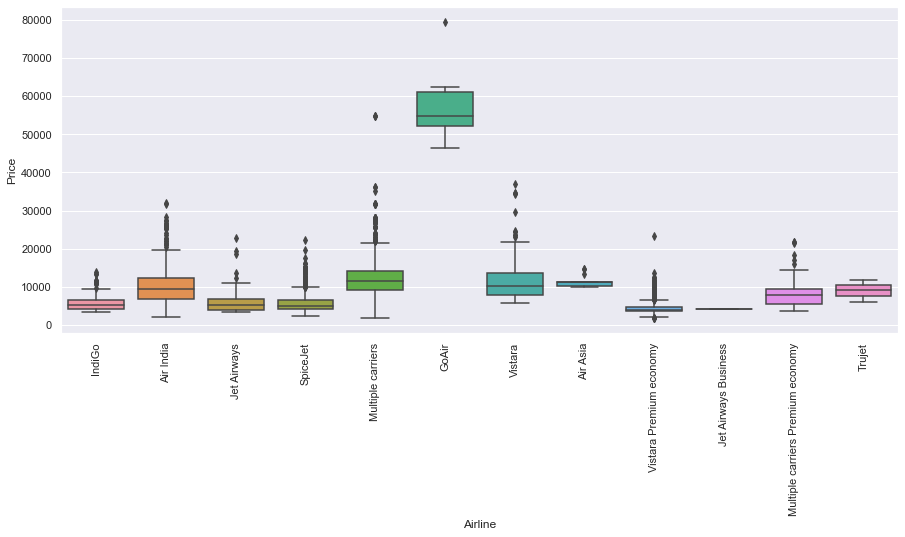

In [159]:
labels = df['Airline'].unique()
sns.boxplot(x = 'Airline', y = 'Price', data = df).set_xticklabels(labels, rotation = 90)

And indeed GoAir is by far the most expensive airline.

Will Additional_info column bring some information abour flight price? 

[Text(0, 0, 'No info'),
 Text(1, 0, 'In-flight meal not included'),
 Text(2, 0, 'No check-in baggage included'),
 Text(3, 0, '1 Short layover'),
 Text(4, 0, 'No Info'),
 Text(5, 0, '1 Long layover'),
 Text(6, 0, 'Change airports'),
 Text(7, 0, 'Business class'),
 Text(8, 0, 'Red-eye flight'),
 Text(9, 0, '2 Long layover')]

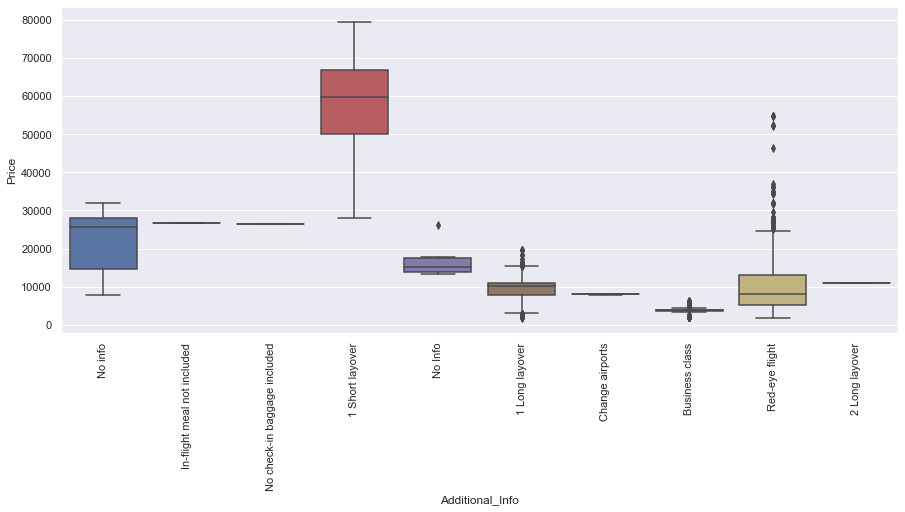

In [160]:
labels = df['Additional_Info'].unique()

sns.boxplot(x = 'Additional_Info', y = 'Price', data = df).set_xticklabels(labels, rotation = 90)

We have explored our dataset, so now find the best regressor based on cross-validation.

In [161]:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error as mse

In [162]:
#prepare Train, and Test dataset
X = df.drop("Price", axis = 1)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

In [163]:
def evaluate_cv(depth, leaf, n, features, kf):
    """
    this function returns list of mean square erorrs in test samples 
    
    :param depth int: maximal depth of tree
    :param leaf int: min number of sample in leaf
    :param n int: number of trees in random forest
    :param features int: maximal number of features for a tree
    :param kf object: cross-validation K-fold object
    """
    global data_inputs, data_outputs, threshold
    
    cvscores = [] 
    
    #create pipeline
    pipeline = make_pipeline(
    make_column_transformer(
        #handle categories
        (OneHotEncoder(handle_unknown = "ignore"), ["Airline", "Source", "Destination", "Additional_Info"]),
        remainder="passthrough",
    ),
        #inicialize model
    RandomForestRegressor(max_depth=depth, min_samples_leaf = leaf ,max_features = features,
                          n_estimators = n ,
                          random_state = 0, bootstrap = True),
    )
    for train, test in kf.split(X_train, y_train):
        # split train data
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train[train], y_train[test]
        
        # define model
        model = pipeline
        
        #fit model
        model.fit(X_train_cv, y_train_cv)  
        
        #predict cross-validation Test data
        predictions = model.predict(X_test_cv) 
        
        #calculate error
        error = mse(predictions, y_test_cv)
        
        #append error to list
        cvscores.append(error)
    #return list with errors
    return cvscores

In [164]:
from sklearn.model_selection import KFold

# inicialize cross validation
kf = KFold(n_splits=5)

# statistical values from from cross validation will be saved in cv_data
cv_data = pd.DataFrame()

# parameters that will be checked
depths = [10, 20, 50]
min_samples_leaf = [1, 100, 250]
n_estim = [5, 10, 20, 50]
max_featues = ["sqrt", None]

for d in depths:
    for n in n_estim:
        for l in min_samples_leaf:  
            for f in max_featues:
                cvscores = evaluate_cv(d, l, n, f,  kf)

                # for every parameter calculate statistical values
                mean = np.mean(cvscores)
                df2 = {"Depth": d, "M_S_L": l, "N_estim": n,"Max_F": str(f), "mean": mean}

                # saving data in cv_data
                cv_data = cv_data.append(df2, ignore_index = True)
cv_data    

,Depth,M_S_L,N_estim,Max_F,mean
0,10.0,1.0,5.0,sqrt,4.921183e+06
1,10.0,1.0,5.0,None,3.665692e+06
2,10.0,100.0,5.0,sqrt,8.642598e+06
3,10.0,100.0,5.0,None,7.068579e+06
4,10.0,250.0,5.0,sqrt,1.008199e+07
...,...,...,...,...,...
67,50.0,1.0,50.0,None,2.643422e+06
68,50.0,100.0,50.0,sqrt,8.448230e+06
69,50.0,100.0,50.0,None,6.728637e+06
70,50.0,250.0,50.0,sqrt,9.787943e+06


Pick the best parametr based on cross-validation and test model on test data

In [165]:
cv_data.loc[cv_data["mean"] == cv_data["mean"].min()]

,Depth,M_S_L,N_estim,Max_F,mean
43,20.0,1.0,50.0,None,2.615422e+06


In [166]:
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = "ignore"), ["Airline", "Source", "Destination", "Additional_Info"]),
        remainder="passthrough",
    ),
    RandomForestRegressor(max_depth=20, min_samples_leaf = 1,max_features = None,
                          n_estimators = 50, 
                          random_state = 0, bootstrap = True),
    )

<Figure size 864x864 with 0 Axes>

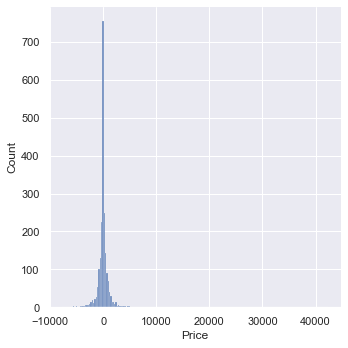

In [167]:
#fit model on train data

pipeline.fit(X_train,y_train)
prediction = pipeline.predict(X_test)

#plot distribution of  differences between true flight price and prediction 
plt.figure(figsize = (12,12))
sns.displot(y_test - prediction, bins = 200)
plt.show()

It looks like our model does a pretty good job, the most of the differences are near to zero.

Now let's plot scatter plot of predictions and true prices. 

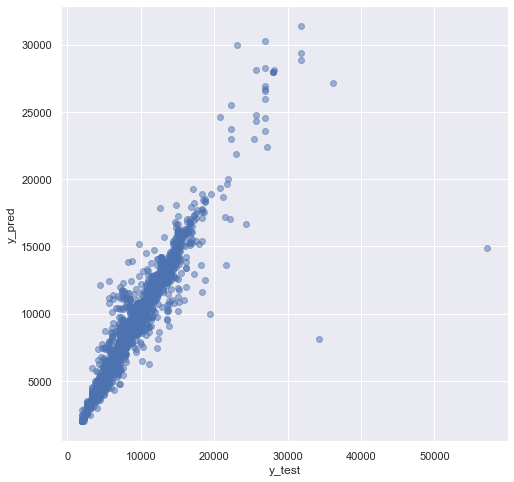

In [168]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Almost all data lies near to imaginary line, which means that the difference between prediction and tru flight price is low. It looks like there are only two outliers, in both cases our model predicted lower prices, then it was.

Let's now check how much vairence can our model explain. 

In [169]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.8857731013791481


88.5% of varience is explained based on features. Let's see if it goes up, if we remove the outliers. 

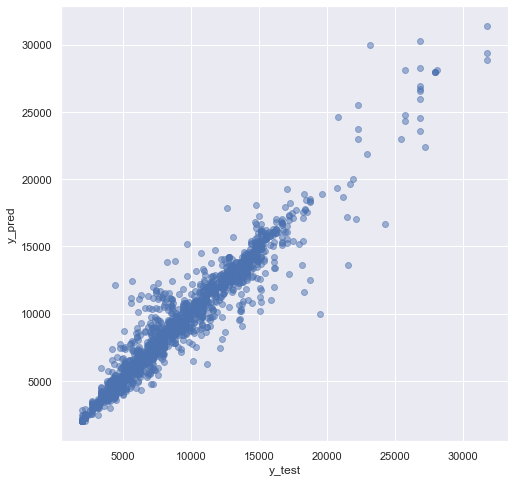

In [170]:
X_test = X_test.loc[y_test < 33000]
y_test = y_test[y_test < 33000]
pipeline.fit(X_train,y_train)
prediction = pipeline.predict(X_test)
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [171]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.9362299411639956


Indeed if we remove only 3 data points, the explained varience goes up to 94%. 